# Description

It analyzes how correlation coefficients intersect on different gene pairs. Basically, I take the top gene pairs with the maximum correlation coefficient according to Pearson, Spearman and Clustermatch, and also the equivalent set with the minimum coefficient values, and then compare how these sets intersect each other.

After identifying different intersection sets, I plot some gene pairs to see what's being captured or not by each coefficient.

# Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import plot, from_indicators

from clustermatch.plots import MyUpSet
from clustermatch import conf

# Settings

In [2]:
DATASET_CONFIG = conf.RECOUNT2FULL
# GTEX_TISSUE = "whole_blood"
GENE_SEL_STRATEGY = "var_pc_log2"

In [3]:
# this specificies the threshold to compare coefficients (see below).
# it basically takes the top Q_DIFF coefficient values for gene pairs
# and compare with the bottom Q_DIFF of the other coefficients
Q_DIFF = 0.30

# Paths

In [4]:
dataset_name = DATASET_CONFIG["RESULTS_DIR"].name
display(dataset_name)

'recount2full'

In [5]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [6]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp" / dataset_name
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/recount2full')

In [7]:
INPUT_GENE_EXPR_FILE = DATASET_CONFIG["DATA_DIR"] / "recount2_rpkm.pkl"
display(INPUT_GENE_EXPR_FILE)

assert INPUT_GENE_EXPR_FILE.exists()

PosixPath('/opt/data/data/recount2full/recount2_rpkm.pkl')

In [8]:
INPUT_CORR_FILE_TEMPLATE = (
    DATASET_CONFIG["SIMILARITY_MATRICES_DIR"]
    / DATASET_CONFIG["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
)
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/opt/data/results/recount2full/similarity_matrices/recount2_rpkm-{gene_sel_strategy}-{corr_method}.pkl')

In [9]:
INPUT_CORR_FILE = DATASET_CONFIG["SIMILARITY_MATRICES_DIR"] / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    gene_sel_strategy=GENE_SEL_STRATEGY,
    corr_method="all",
)
display(INPUT_CORR_FILE)

assert INPUT_CORR_FILE.exists()

PosixPath('/opt/data/results/recount2full/similarity_matrices/recount2_rpkm-var_pc_log2-all.pkl')

# Data

## Gene expression

In [10]:
gene_expr_df = pd.read_pickle(INPUT_GENE_EXPR_FILE)

In [11]:
gene_expr_df.shape

(57096, 37032)

In [12]:
gene_expr_df.head()

,SRP000599.SRR013549,SRP000599.SRR013550,SRP000599.SRR013551,SRP000599.SRR013552,SRP000599.SRR013553,SRP000599.SRR013554,SRP000599.SRR013555,SRP000599.SRR013556,SRP000599.SRR013557,SRP000599.SRR013558,...,SRP035599.SRR1139372,SRP035599.SRR1139393,SRP035599.SRR1139388,SRP035599.SRR1139378,SRP035599.SRR1139399,SRP035599.SRR1139386,SRP035599.SRR1139375,SRP035599.SRR1139382,SRP035599.SRR1139356,SRP035599.SRR1139370
ENSG00000000003,0.000000,0.0,0.000000,0.0,0.0,0.0,0.929351,1.175312,0.459859,1.254482,...,0.017900,0.029771,0.081792,0.000000,0.064336,0.408565,0.000000,0.010008,0.000000,0.027440
ENSG00000000005,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,5.561367,2.945875,...,29.761841,37.385839,20.649367,30.926951,23.025321,24.162726,11.302146,30.588071,20.268225,14.817692
ENSG00000000457,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.262267,...,3.886637,4.945604,2.421947,4.127070,2.597540,2.692441,3.784122,2.715137,3.255437,2.210011
ENSG00000000460,0.084565,0.0,0.497083,0.0,0.0,0.0,1.177199,0.000000,0.000000,0.000000,...,2.585671,3.580650,1.800513,3.013335,2.352776,1.680907,2.413180,2.202502,1.720274,2.199518


## Correlation

In [13]:
df = pd.read_pickle(INPUT_CORR_FILE)

In [14]:
df.shape

(12497500, 3)

In [15]:
df.head()

clustermatch   pearson  spearman
ENSG00000000003 ENSG00000000419      0.163960  0.130873  0.471673
                ENSG00000000938      0.083831  0.107588  0.178042
                ENSG00000001036      0.274535  0.047559  0.494995
                ENSG00000001630      0.194099  0.226343  0.547457
                ENSG00000002586      0.067899  0.011981  0.204876

In [16]:
# show quantiles
df.apply(lambda x: x.quantile(np.linspace(0.20, 1.0, 20)))

,clustermatch,pearson,spearman
0.200000,0.043123,0.010266,0.117181
0.242105,0.050383,0.012494,0.140243
0.284211,0.057064,0.014813,0.162699
0.326316,0.063160,0.017263,0.184437
0.368421,0.068828,0.019866,0.205521
0.410526,0.074245,0.022672,0.226145
0.452632,0.079615,0.025700,0.246302
0.494737,0.085087,0.029010,0.266180
0.536842,0.090757,0.032677,0.286041
0.578947,0.096683,0.036766,0.306200


# Prepare data for plotting

In [17]:
def get_lower_upper_quantile(method_name, q):
    return df[method_name].quantile([q, 1 - q])

In [18]:
# test
_tmp = get_lower_upper_quantile("clustermatch", 0.20)
display(_tmp)

_tmp0, _tmp1 = _tmp
display((_tmp0, _tmp1))

assert _tmp0 == _tmp.iloc[0]
assert _tmp1 == _tmp.iloc[1]

0.2    0.043123
0.8    0.137485
Name: clustermatch, dtype: float64

(0.04312262638172756, 0.13748539947404223)

In [19]:
clustermatch_lq, clustermatch_hq = get_lower_upper_quantile("clustermatch", Q_DIFF)
display((clustermatch_lq, clustermatch_hq))

pearson_lq, pearson_hq = get_lower_upper_quantile("pearson", Q_DIFF)
display((pearson_lq, pearson_hq))

spearman_lq, spearman_hq = get_lower_upper_quantile("spearman", Q_DIFF)
display((spearman_lq, spearman_hq))

(0.059407414520353446, 0.11578220263694407)

(0.015718068271912643, 0.05236733091059872)

(0.1709306151554558, 0.36973936939313695)

In [20]:
pearson_higher = df["pearson"] >= pearson_hq
display(pearson_higher.sum())

pearson_lower = df["pearson"] <= pearson_lq
display(pearson_lower.sum())

3749250

3749250

In [21]:
spearman_higher = df["spearman"] >= spearman_hq
display(spearman_higher.sum())

spearman_lower = df["spearman"] <= spearman_lq
display(spearman_lower.sum())

3749250

3749250

In [22]:
clustermatch_higher = df["clustermatch"] >= clustermatch_hq
display(clustermatch_higher.sum())

clustermatch_lower = df["clustermatch"] <= clustermatch_lq
display(clustermatch_lower.sum())

3749250

3749250

# UpSet plot

In [23]:
df_plot = pd.DataFrame(
    {
        "pearson_higher": pearson_higher,
        "pearson_lower": pearson_lower,
        "spearman_higher": spearman_higher,
        "spearman_lower": spearman_lower,
        "clustermatch_higher": clustermatch_higher,
        "clustermatch_lower": clustermatch_lower,
    }
)

In [24]:
df_plot = pd.concat([df_plot, df], axis=1)

In [25]:
df_plot

pearson_higher  pearson_lower  \
ENSG00000000003 ENSG00000000419            True          False   
                ENSG00000000938            True          False   
                ENSG00000001036           False          False   
                ENSG00000001630            True          False   
                ENSG00000002586           False           True   
...                                         ...            ...   
ENSG00000283696 ENSG00000283534           False           True   
                ENSG00000283551           False           True   
                ENSG00000283604           False           True   
                ENSG00000283612           False          False   
                ENSG00000283638            True          False   

                                 spearman_higher  spearman_lower  \
ENSG00000000003 ENSG00000000419             True           False   
                ENSG00000000938            False           False   
                ENSG00000001036             True           False   
                ENSG00000001630             True           False   
                ENSG00000002586            False           False   
...                                          ...             ...   
ENSG00000283696 ENSG00000283534             True           False   
                ENSG00000283551             True           False   
                ENSG00000283604             True           False   
                ENSG00000283612             True           False   
                ENSG00000283638            False           False   

                                 clustermatch_higher  clustermatch_lower  \
ENSG00000000003 ENSG00000000419                 True               False   
                ENSG00000000938                False               False   
                ENSG00000001036                 True               False   
                ENSG00000001630                 True               False   
                ENSG00000002586                False               False   
...                                              ...                 ...   
ENSG00000283696 ENSG00000283534                 True               False   
                ENSG00000283551                 True               False   
                ENSG00000283604                False                True   
                ENSG00000283612                False                True   
                ENSG00000283638                False               False   

                                 clustermatch   pearson  spearman  
ENSG00000000003 ENSG00000000419      0.163960  0.130873  0.471673  
                ENSG00000000938      0.083831  0.107588  0.178042  
                ENSG00000001036      0.274535  0.047559  0.494995  
                ENSG00000001630      0.194099  0.226343  0.547457  
                ENSG00000002586      0.067899  0.011981  0.204876  
...                                       ...       ...       ...  
ENSG00000283696 ENSG00000283534      0.163422  0.014953  0.414759  
                ENSG00000283551      0.215277  0.014696  0.462265  
                ENSG00000283604      0.058451  0.012938  0.396307  
                ENSG00000283612      0.059039  0.017648  0.423558  
                ENSG00000283638      0.112061  0.053365  0.358252  

[12497500 rows x 9 columns]

In [26]:
assert not df_plot.isna().any().any()

In [27]:
df_plot = df_plot.rename(
    columns={
        "pearson_higher": "Pearson (high)",
        "pearson_lower": "Pearson (low)",
        "spearman_higher": "Spearman (high)",
        "spearman_lower": "Spearman (low)",
        "clustermatch_higher": "Clustermatch (high)",
        "clustermatch_lower": "Clustermatch (low)",
    }
)

In [28]:
categories = sorted(
    [x for x in df_plot.columns if " (" in x],
    reverse=True,
    key=lambda x: x.split(" (")[1] + " (" + x.split(" (")[0],
)

In [29]:
categories

['Spearman (low)',
 'Pearson (low)',
 'Clustermatch (low)',
 'Spearman (high)',
 'Pearson (high)',
 'Clustermatch (high)']

## All subsets (original full plot)

In [30]:
df_r_data = df_plot

In [31]:
df_r_data.shape

(12497500, 9)

In [32]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [33]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                False           True           False                          True   
                                                True            False          True                          False   
                                                                True           True                           True   
               True          False              False           False          False                         False   
...                                                                                                            ...   
                                                True            False          True                          False   
                                                                               True                          False   
                             True               True            False          False                         False   
               False         True               True            False          False                         False   
                             False              False           True           False                          True   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                False           True           False                        False   
                                                True            False          True                         False   
                                                                True           True                         False   
               True          False              False           False          False                         True   
...                                                                                                           ...   
                                                True            False          True                          True   
                                                                               True                          True   
                             True               True            False          False                         True   
               False         True               True            False          False                        False   
                             False              False           True           False                        False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                False           True           False                          False   
                                                True            False          True                            True   
                                                                True           True                            True   
               True          False              False           False          False                          False   
...                                                                                                             ...   
                                                True            False          True        

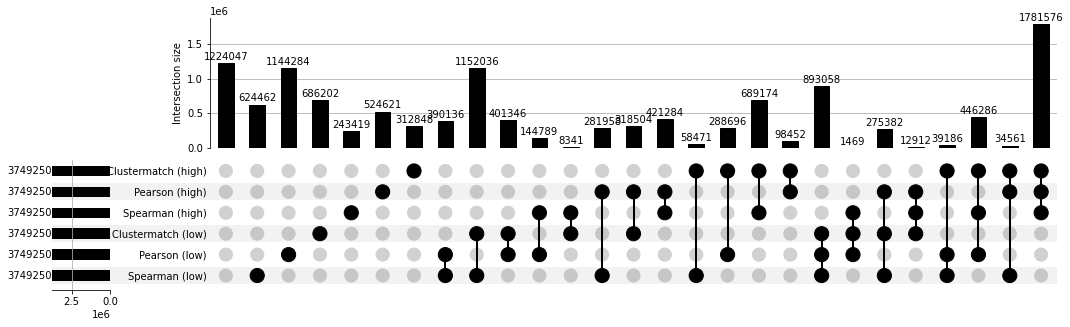

In [34]:
fig = plt.figure(figsize=(18, 5))

g = plot(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    element_size=None,
    fig=fig,
)

## Sort by categories of subsets

In [35]:
df_r_data = df_plot

In [36]:
df_r_data.shape

(12497500, 9)

In [37]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [38]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                False           True           False                          True   
                                                True            False          True                          False   
                                                                True           True                           True   
               True          False              False           False          False                         False   
...                                                                                                            ...   
                                                True            False          True                          False   
                                                                               True                          False   
                             True               True            False          False                         False   
               False         True               True            False          False                         False   
                             False              False           True           False                          True   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                False           True           False                        False   
                                                True            False          True                         False   
                                                                True           True                         False   
               True          False              False           False          False                         True   
...                                                                                                           ...   
                                                True            False          True                          True   
                                                                               True                          True   
                             True               True            False          False                         True   
               False         True               True            False          False                        False   
                             False              False           True           False                        False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                False           True           False                          False   
                                                True            False          True                            True   
                                                                True           True                            True   
               True          False              False           False          False                          False   
...                                                                                                             ...   
                                                True            False          True        

In [39]:
gene_pairs_by_cats = gene_pairs_by_cats.sort_index()

In [40]:
_tmp_index = gene_pairs_by_cats.index.unique().to_frame(False)
display(_tmp_index)

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
0,False,False,False,False,False,False
1,False,False,False,False,False,True
2,False,False,False,False,True,False
3,False,False,False,False,True,True
4,False,False,False,True,False,False
5,False,False,False,True,False,True
6,False,False,False,True,True,False
7,False,False,False,True,True,True
8,False,False,True,False,False,False
9,False,False,True,False,True,False


In [41]:
_tmp_index[_tmp_index.sum(axis=1) == 3]

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
7,False,False,False,True,True,True
11,False,False,True,True,True,False
15,False,True,False,True,False,True
17,False,True,True,True,False,False
21,True,False,False,False,True,True
23,True,False,True,False,True,False
25,True,True,False,False,False,True
26,True,True,True,False,False,False


In [42]:
_tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
dtype: bool

In [43]:
# agreements on top
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[3:].sum() > 1, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, False, False, True, True),
       (False, False, False, True, False, True),
       (False, False, False, True, True, False)], dtype=object)

In [44]:
# agreements on bottom
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[0:3].sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() == 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, True, True, False, False, False),
       (True, False, True, False, False, False),
       (True, True, False, False, False, False)], dtype=object)

In [45]:
# diagreements
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() > 0, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() > 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, True, False, True, False),
       (False, False, True, True, False, False),
       (False, False, True, True, True, False),
       (False, True, False, False, False, True),
       (False, True, False, True, False, False),
       (False, True, False, True, False, True),
       (False, True, True, True, False, False),
       (True, False, False, False, False, True),
       (True, False, False, False, True, False),
       (True, False, False, False, True, True),
       (True, False, True, False, True, False),
       (True, True, False, False, False, True)], dtype=object)

In [46]:
# order subsets
gene_pairs_by_cats = gene_pairs_by_cats.loc[
    [
        # pairs not included in categories:
        # (False, False, False, False, False, False),
        # full agreements on high:
        (False, False, False, True, True, True),
        # agreements on top
        (False, False, False, False, True, True),
        (False, False, False, True, False, True),
        (False, False, False, True, True, False),
        # agreements on bottom
        (False, True, True, False, False, False),
        (True, False, True, False, False, False),
        (True, True, False, False, False, False),
        # full agreements on low:
        (True, True, True, False, False, False),
        # diagreements
        ## clustermatch
        (True, False, False, False, True, True),
        (False, True, False, True, False, True),
        (False, True, False, False, False, True),
        (True, False, False, False, False, True),
        (True, True, False, False, False, True),
        ## pearson
        (False, False, True, False, True, False),
        (True, False, False, False, True, False),
        (True, False, True, False, True, False),
        (False, False, True, True, True, False),
        ## spearman
        (False, False, True, True, False, False),
        (False, True, False, True, False, False),
        (False, True, True, True, False, False),
    ]
]

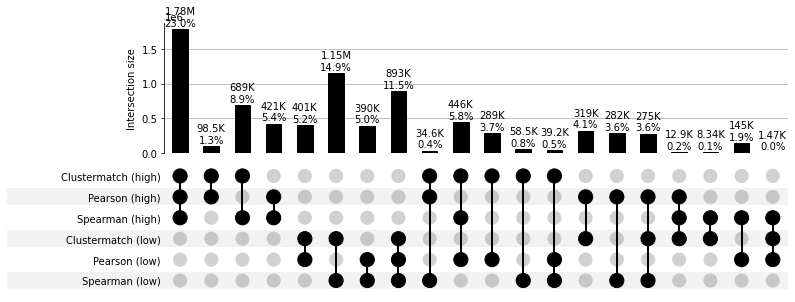

In [47]:
fig = plt.figure(figsize=(14, 5))

# g = plot(
g = MyUpSet(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    sort_by=None,
    show_percentages=True,
    # min_subset_size=2,
    element_size=None,
    # fig=fig,
).plot(fig)

g["totals"].remove()  # set_visible(False)

# display(fig.get_size_inches())
# fig.set_size_inches(12, 5)

plt.savefig(
    OUTPUT_FIGURE_DIR / "upsetplot.svg",
    bbox_inches="tight",
    facecolor="white",
)

# plt.margins(x=-0.4)

This plot has the sets that represent agreements on the left, and disagreements on the right. The plot shown here is not the final one for the manuscript.

# Save groups of gene pairs in each subset

In [48]:
display(df_plot.shape)
display(df_plot.head())

(12497500, 9)

Pearson (high)  Pearson (low)  \
ENSG00000000003 ENSG00000000419            True          False   
                ENSG00000000938            True          False   
                ENSG00000001036           False          False   
                ENSG00000001630            True          False   
                ENSG00000002586           False           True   

                                 Spearman (high)  Spearman (low)  \
ENSG00000000003 ENSG00000000419             True           False   
                ENSG00000000938            False           False   
                ENSG00000001036             True           False   
                ENSG00000001630             True           False   
                ENSG00000002586            False           False   

                                 Clustermatch (high)  Clustermatch (low)  \
ENSG00000000003 ENSG00000000419                 True               False   
                ENSG00000000938                False               False   
                ENSG00000001036                 True               False   
                ENSG00000001630                 True               False   
                ENSG00000002586                False               False   

                                 clustermatch   pearson  spearman  
ENSG00000000003 ENSG00000000419      0.163960  0.130873  0.471673  
                ENSG00000000938      0.083831  0.107588  0.178042  
                ENSG00000001036      0.274535  0.047559  0.494995  
                ENSG00000001630      0.194099  0.226343  0.547457  
                ENSG00000002586      0.067899  0.011981  0.204876

In [49]:
conf.RECOUNT2FULL["GENE_PAIR_INTERSECTIONS"].mkdir(parents=True, exist_ok=True)

In [50]:
output_file = (
    conf.RECOUNT2FULL["GENE_PAIR_INTERSECTIONS"]
    / f"gene_pair_intersections-{dataset_name}-{GENE_SEL_STRATEGY}.pkl"
)
display(output_file)

PosixPath('/opt/data/results/recount2full/gene_pair_intersections/gene_pair_intersections-recount2full-var_pc_log2.pkl')

In [51]:
df_plot.to_pickle(output_file)

In [52]:
# DELETE ALL BELOW

# Look at specific gene pair cases

In [ ]:
def plot_gene_pair(top_pairs_df, idx, bins="log"):
    gene0, gene1 = top_pairs_df.iloc[idx].name
    display((gene0, gene1))

    # gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    # display((gene0_symbol, gene1_symbol))

    _pearson, _spearman, _clustermatch = top_pairs_df.loc[
        (gene0, gene1), ["pearson", "spearman", "clustermatch"]
    ].tolist()

    _title = f"Clustermatch: {_clustermatch:.2f}\nPearson/Spearman: {_pearson:.2f}/{_spearman:.2f}"

    # displot DOES SUPPORT HUE!
    p = sns.jointplot(
        data=gene_expr_df.T,
        x=gene0,
        y=gene1,
        kind="hex",
        bins=bins,
        # ylim=(0, 500),
    )

    gene_x_id = p.ax_joint.get_xlabel()
    # gene_x_symbol = gene_map[gene_x_id]
    p.ax_joint.set_xlabel(f"{gene_x_id}")

    gene_y_id = p.ax_joint.get_ylabel()
    # gene_y_symbol = gene_map[gene_y_id]
    p.ax_joint.set_ylabel(f"{gene_y_id}")

    p.fig.suptitle(_title)

    return p

In [ ]:
# add columns with ranks
df_r_data = pd.concat(
    [
        df_r_data,
        df_r_data[["clustermatch", "pearson", "spearman"]]
        .rank()
        .rename(
            columns={
                "clustermatch": "clustermatch_rank",
                "pearson": "pearson_rank",
                "spearman": "spearman_rank",
            }
        ),
    ],
    axis=1,
)

In [ ]:
df_r_data.head()

## Clustermatch vs Spearman

In [ ]:
first_coef = "clustermatch"
second_coef = "spearman"

In [ ]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & ~(df_r_data["Pearson (low)"])
]

_tmp_df = _tmp_df.assign(
    rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_tmp_df[f"{second_coef}_rank"])
)

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df[[x for x in _tmp_df.columns if " (" not in x]].sort_values(
    "rank_diff", ascending=False
)

# sort by firt_coef value
# _tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
#     first_coef, ascending=False
# )

# display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
for i in range(10):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

In [ ]:
# reverse order
for i in range(1, 3):
    i = -i
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Clustermatch vs Pearson

In [ ]:
first_coef = "clustermatch"
second_coef = "pearson"

In [ ]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & ~(df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

_tmp_df = _tmp_df.assign(
    rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_tmp_df[f"{second_coef}_rank"])
)

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df[[x for x in _tmp_df.columns if " (" not in x]].sort_values(
    "rank_diff", ascending=False
)

# sort by firt_coef value
# _tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
#     first_coef, ascending=False
# )

# display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
for i in range(10):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

In [ ]:
# reverse order
for i in range(1, 5):
    i = -i
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Clustermatch vs Spearman/Pearson

In [ ]:
first_coef = "clustermatch"
second_coef = "pearson"
second_1_coef = "spearman"

In [ ]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

_tmp_df = _tmp_df.assign(
    rank_diff=_tmp_df[f"{first_coef}_rank"].sub(
        _tmp_df[f"{second_coef}_rank"].add(_tmp_df[f"{second_1_coef}_rank"])
    )
)

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df[[x for x in _tmp_df.columns if " (" not in x]].sort_values(
    "rank_diff", ascending=False
)

# sort by firt_coef value
# _tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
#     first_coef, ascending=False
# )

# display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
for i in range(5):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

In [ ]:
# reverse order
for i in range(1, 5):
    i = -i
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

In [ ]:
# I NEED TO CHANGE THE CODE BELOW TO UPDATE IT WITH THE ONE ABOVE

## Clustermatch/Spearman vs Pearson

In [ ]:
_tmp_df = df_r_data[
    (df_r_data["clustermatch_higher"])
    & (df_r_data["spearman_higher"])
    & ~(df_r_data["pearson_higher"])
    & ~(df_r_data["clustermatch_lower"])
    & ~(df_r_data["spearman_lower"])
    & (df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "clustermatch", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

In [ ]:
plot_gene_pair(_tmp_df, 2)

## Pearson vs Spearman

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & ~(df_r_data["spearman_higher"])
    & (df_r_data["pearson_higher"])
    & ~(df_r_data["clustermatch_lower"])
    & (df_r_data["spearman_lower"])
    & ~(df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

In [ ]:
plot_gene_pair(_tmp_df, 2)

## Spearman vs Pearson

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & (df_r_data["spearman_higher"])
    & ~(df_r_data["pearson_higher"])
    & ~(df_r_data["clustermatch_lower"])
    & ~(df_r_data["spearman_lower"])
    & (df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

## Pearson vs Spearman/Clustermatch

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & ~(df_r_data["spearman_higher"])
    & (df_r_data["pearson_higher"])
    & (df_r_data["clustermatch_lower"])
    & (df_r_data["spearman_lower"])
    & ~(df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
plot_gene_pair(_tmp_df, 1)

## Pearson vs Clustermatch

In [ ]:
_tmp_df = df_r_data[
    ~(df_r_data["clustermatch_higher"])
    & ~(df_r_data["spearman_higher"])
    & (df_r_data["pearson_higher"])
    & (df_r_data["clustermatch_lower"])
    & ~(df_r_data["spearman_lower"])
    & ~(df_r_data["pearson_lower"])
]

# show this just to make sure of the groups
# display(_tmp_df.head())

_tmp_df = _tmp_df[[x for x in df_r_data.columns if "_" not in x]].sort_values(
    "pearson", ascending=False
)

display(_tmp_df.shape)
display(_tmp_df)

In [ ]:
plot_gene_pair(_tmp_df, 0)

In [ ]:
gene0, gene1 = (
    gene_expr_df.loc["ENSG00000130598.15"].copy(),
    gene_expr_df.loc["ENSG00000177791.11"].copy(),
)

In [ ]:
cm(gene0, gene1)

In [ ]:
q = 0.75
gene0[gene0 <= gene0.quantile(q)] = 0
gene0[gene0 > gene0.quantile(q)] = 1

gene1[gene1 <= gene1.quantile(q)] = 0
gene1[gene1 > gene1.quantile(q)] = 1

cm(gene0, gene1)

In [ ]:
plot_gene_pair(_tmp_df, 500)

In [ ]:
gene0, gene1 = (
    gene_expr_df.loc["ENSG00000177409.11"].copy(),
    gene_expr_df.loc["ENSG00000149131.15"].copy(),
)

In [ ]:
cm(gene0, gene1)

In [ ]:
q = 0.75
gene0[gene0 <= gene0.quantile(q)] = 0
gene0[gene0 > gene0.quantile(q)] = 1

gene1[gene1 <= gene1.quantile(q)] = 0
gene1[gene1 > gene1.quantile(q)] = 1

cm(gene0, gene1)